# HANNAH Introduction
## AutoML School 2024 Hannover
### Christoph Gerum & Moritz Reiber

# About Us


# HANNAH
## Hardware Accelerator and Neural Network seArcH

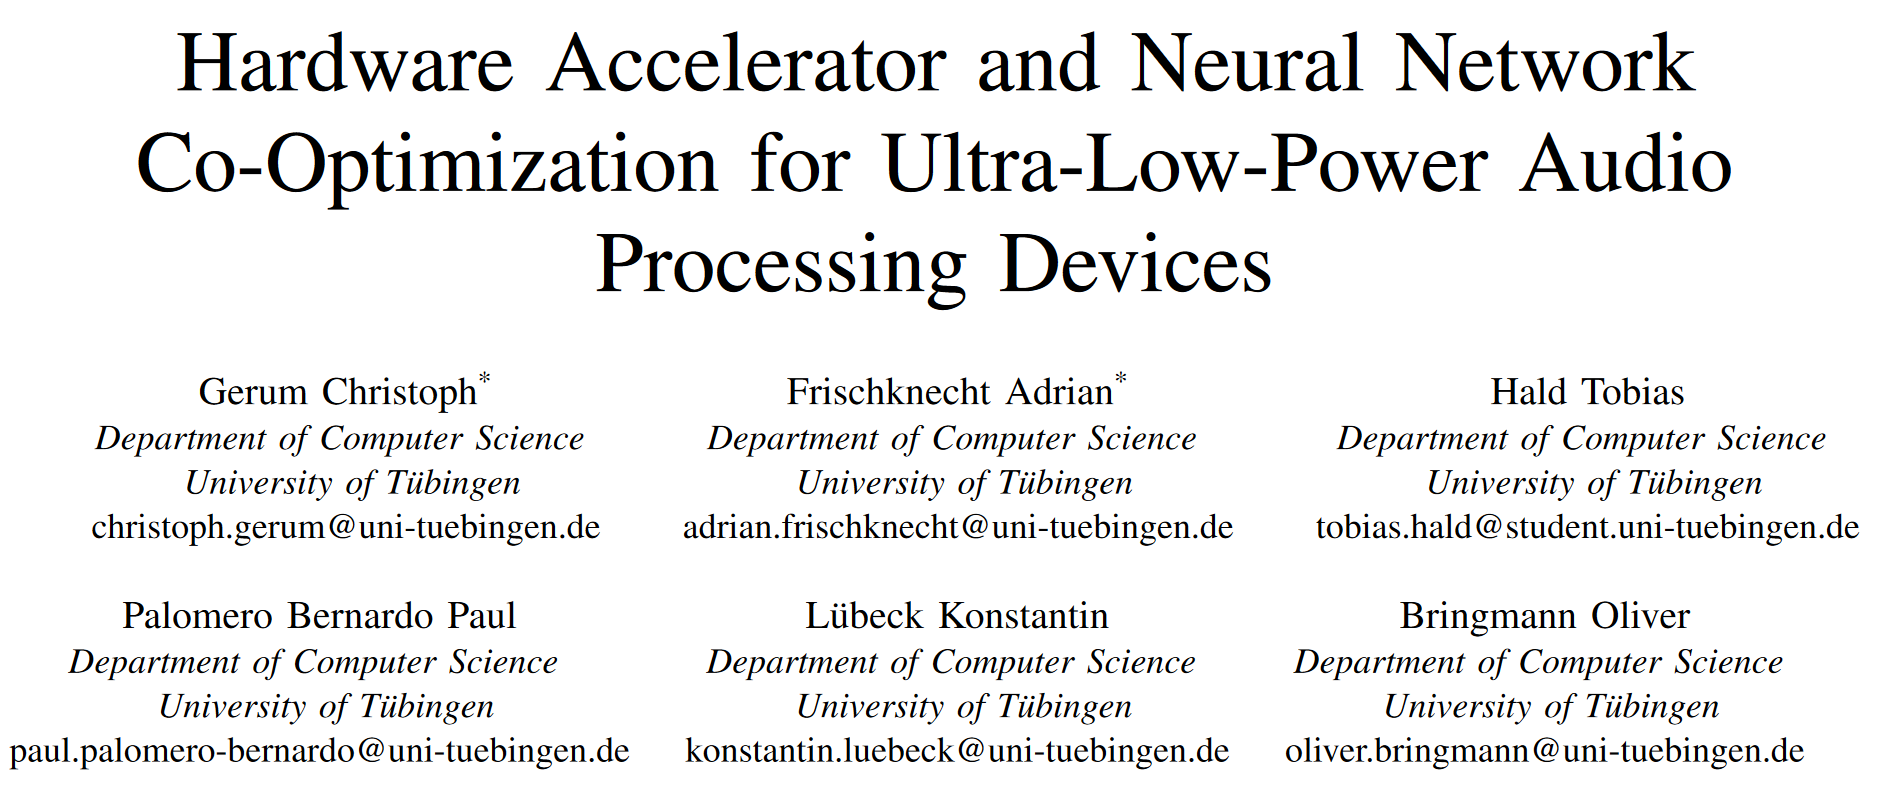

# HANNAH: Overview

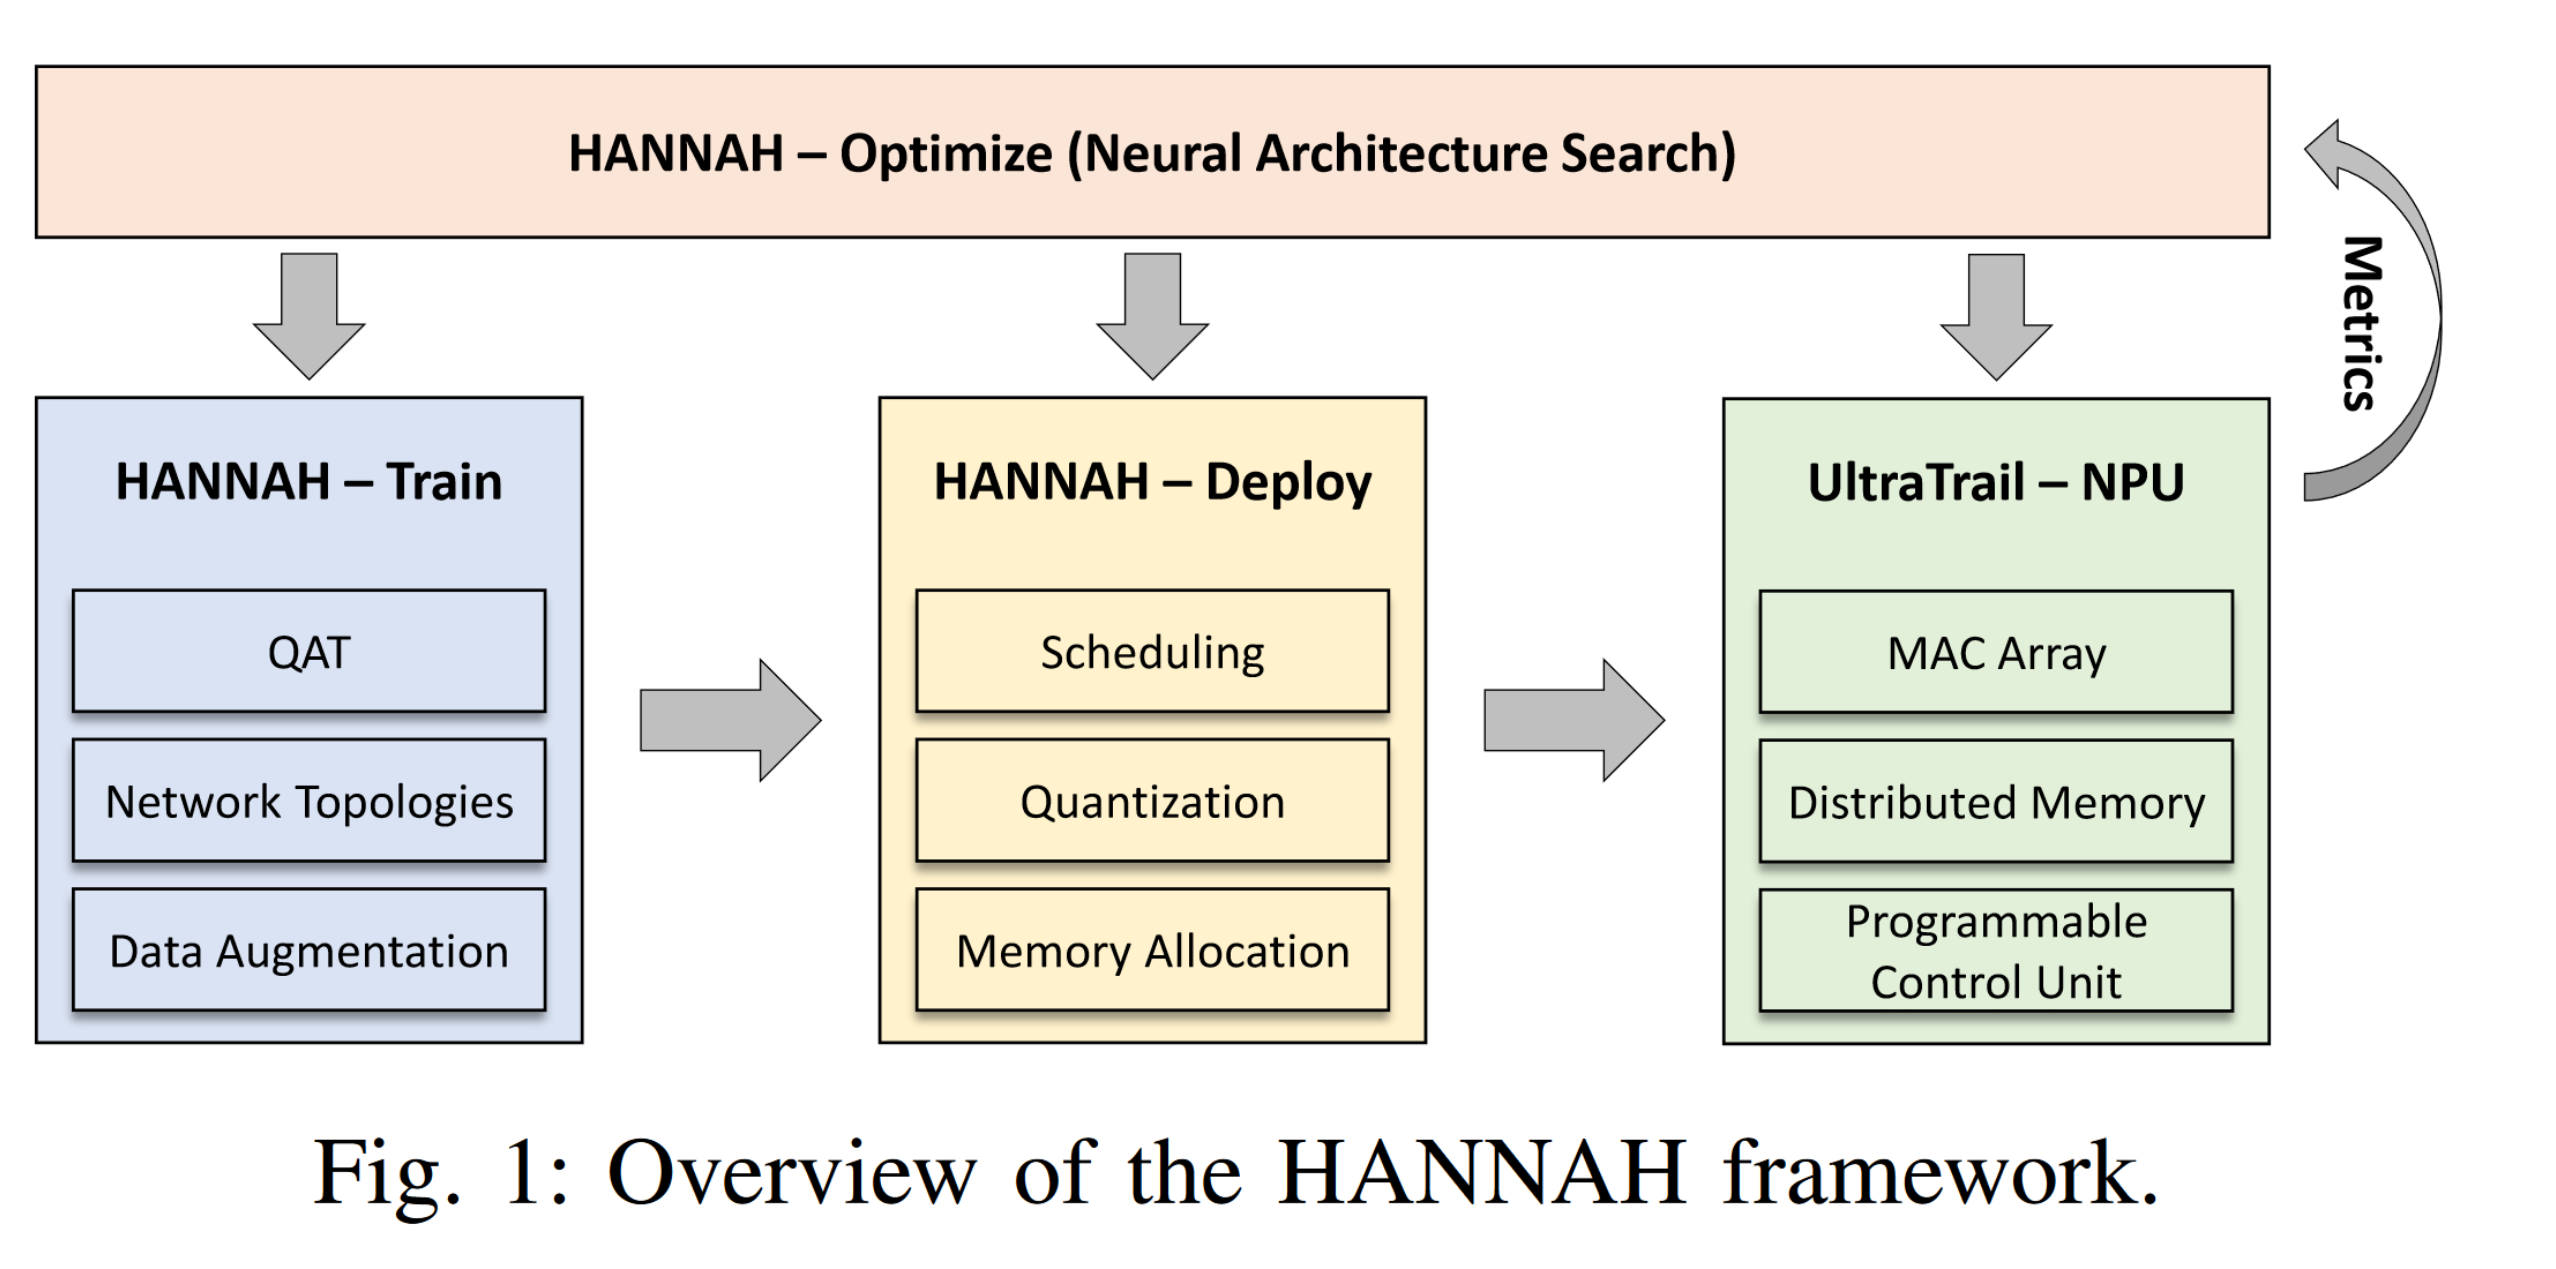

# Motivation & Features

## Search Spaces

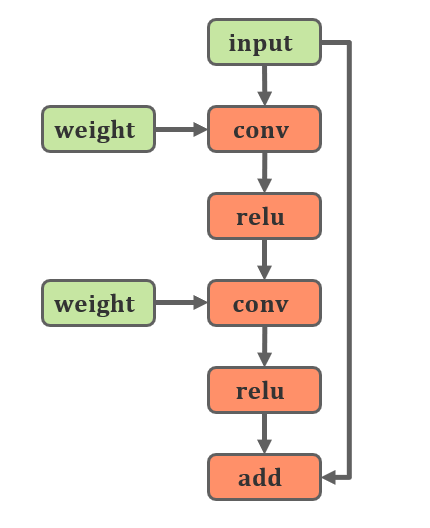

In [4]:
from hannah.nas.parameters.parameters import CategoricalParameter, IntScalarParameter, FloatScalarParameter
from hannah.nas.functional_operators.op import Tensor, scope, ChoiceOp, get_nodes, search_space
from hannah.nas.functional_operators.operators import Conv2d, Linear, Add, Identity, AdaptiveAvgPooling, BatchNorm, Relu, AvgPooling
from hannah.nas.expressions.arithmetic import Ceil
from hannah.nas.expressions.types import Int
from hannah.nas.functional_operators.lazy import lazy
from hannah.nas.functional_operators.shapes import conv_shape
from functools import partial
from hannah.nas.functional_operators.executor import BasicExecutor
import torch

In [17]:
@search_space
def search_space_graph():
    input = Tensor(name='input',
                        shape=(1, 3, 32, 32),
                        axis=('N', 'C', 'H', 'W'),
                        grad=False)
    weight = Tensor(name='weight',
                        shape=(16, 3, 5, 5),
                        axis=('O', 'I', 'kH', 'kW'),
                        grad=True)
    conv = Conv2d(stride=1, dilation=1, groups=1, padding=0)(input, weight)
    return conv
graph = search_space_graph()

In [18]:
graph

Conv2d(search_space_graph_0.Conv2d_0)

In [19]:
graph.operands

[Tensor(search_space_graph_0.input),
 Tensor(search_space_graph_0.Conv2d_0.weight)]

In [20]:
def conv2d(input, out_channels, kernel_size=1, stride=1, dilation=1, groups=1, padding=None):
    in_channels = input.shape()[1]
    weight = Tensor(name='weight',
                    shape=(out_channels, in_channels, kernel_size, kernel_size),
                    axis=('O', 'I', 'kH', 'kW'),
                    grad=True)

    conv = Conv2d(stride=stride, dilation=dilation, groups=groups, padding=padding)(input, weight)
    return conv

In [21]:
def input_tensor(shape=(1, 3, 32, 32)):
    return Tensor(name='input',
                  shape=shape,
                  axis=('N', 'C', 'H', 'W'),
                  grad=False)


In [25]:
@search_space
def search_space_graph_v2():
    input = input_tensor()
    return conv2d(input, out_channels=16, kernel_size=5, stride=1)
graph = search_space_graph_v2()

In [26]:
graph

Conv2d(search_space_graph_v2_0.Conv2d_0)

In [27]:
graph.operands

[Tensor(search_space_graph_v2_0.input),
 Tensor(search_space_graph_v2_0.Conv2d_0.weight)]

In [28]:
def linear(input, out_features):
    input_shape = input.shape()
    in_features = input_shape[1] * input_shape[2] * input_shape[3]
    weight = Tensor(name='weight',
                    shape=(in_features, out_features),
                    axis=('in_features', 'out_features'),
                    grad=True)
    out = Linear()(input, weight)
    return out

In [29]:
def add(input, other):
    return Add()(input, other)

In [31]:
def identity(input):
    return Identity()(input)

In [32]:
def adaptive_avg_pooling(input):
    return AdaptiveAvgPooling()(input)

In [33]:
def batch_norm(input):
    n_chans = input.shape()[1]
    running_mu = Tensor(name='running_mean', shape=(n_chans,), axis=('c',))
    running_std = Tensor(name='running_std', shape=(n_chans,), axis=('c',))
    return BatchNorm()(input, running_mu, running_std)

In [34]:
def relu(input):
    return Relu()(input)

# Scopes

In [ ]:
@scope
def conv_relu(input, out_channels, kernel_size, stride):
    out = conv2d(input, out_channels=out_channels, stride=stride, kernel_size=kernel_size)
    out = relu(out)
    return out